# 주식 예측하기

## 데이터 다운로드
- [야후 주식](https://finance.yahoo.com/) 에서 주식 데이터 다운로드
- 검색창에 종목명 검색 -> 'Historical Data' 탭 -> 'Time Period'를 max로 선택 -> 'Apply' -> 'Download'
```python
$ mv ~/다운로드/005930.KS.csv ~/aiffel/stock_prediction/data
```

## STEP 1: 시계열 데이터 준비
- 칼럼 종류 : Date, Open, High, Low, Close, Adj Close, Volume (날짜, 시작가, 최고가, 최저가, 종가, 수정종가, 거래량)
- 여기서 close만 사용하여 분석

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

csv_path = os.getenv("HOME") + ('/aiffel/stock_prediction/data/005930.KS.csv')
df = pd.read_csv(csv_path)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,0.090599,74195000.0
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,0.082740,74680000.0
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,0.083333,54390000.0
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,0.082147,40305000.0
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,0.085558,46880000.0


In [10]:
df = pd.read_csv(csv_path, index_col = 'Date', parse_dates = True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,0.090599,74195000.0
2000-01-05,5800.0,6060.0,5520.0,5580.0,0.082740,74680000.0
2000-01-06,5750.0,5780.0,5580.0,5620.0,0.083333,54390000.0
2000-01-07,5560.0,5670.0,5360.0,5540.0,0.082147,40305000.0
2000-01-10,5600.0,5770.0,5580.0,5770.0,0.085558,46880000.0


In [11]:
ts = df['Close']
ts.head()

Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64

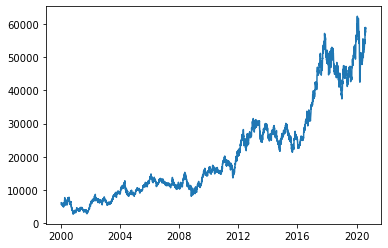

In [16]:
plt.plot(ts)

## STEP 2: 전처리 수행
- 결측치 처리
- 로그 변환

In [12]:
# 결측치 처리
ts[ts.isna()] # Time series 에서 결측치가 있는 부분만 Series로 출력

Date
2000-12-25   NaN
2001-01-23   NaN
2001-01-24   NaN
2001-01-25   NaN
2001-03-14   NaN
2005-01-03   NaN
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64

In [13]:
ts = ts.interpolate(method="time")
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

- [결측값 보간](https://rfriend.tistory.com/tag/interpolate%28method=%27time%27%29)

In [15]:
# 로그 변환
ts_log = np.log(ts)

## STEP 3: 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [24]:
def plot_rolling_statistics(timeseries, window=12):
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label="Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean & Std")
    plt.show(block=False)

In [18]:
from statsmodels.tsa.stattools import adfuller
def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag="AIC")
    print("Results of Dickey-Fuller Test:")
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

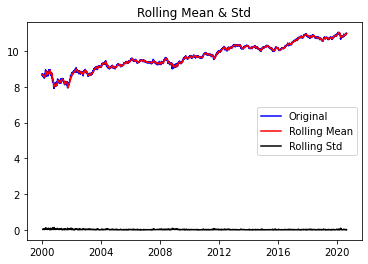

Results of Dickey-Fuller Test:
Test Statistic                   -0.687281
p-value                           0.850017
#Lags Used                        4.000000
Number of Observations Used    5182.000000
Critical Value (1%)              -3.431613
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


In [26]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

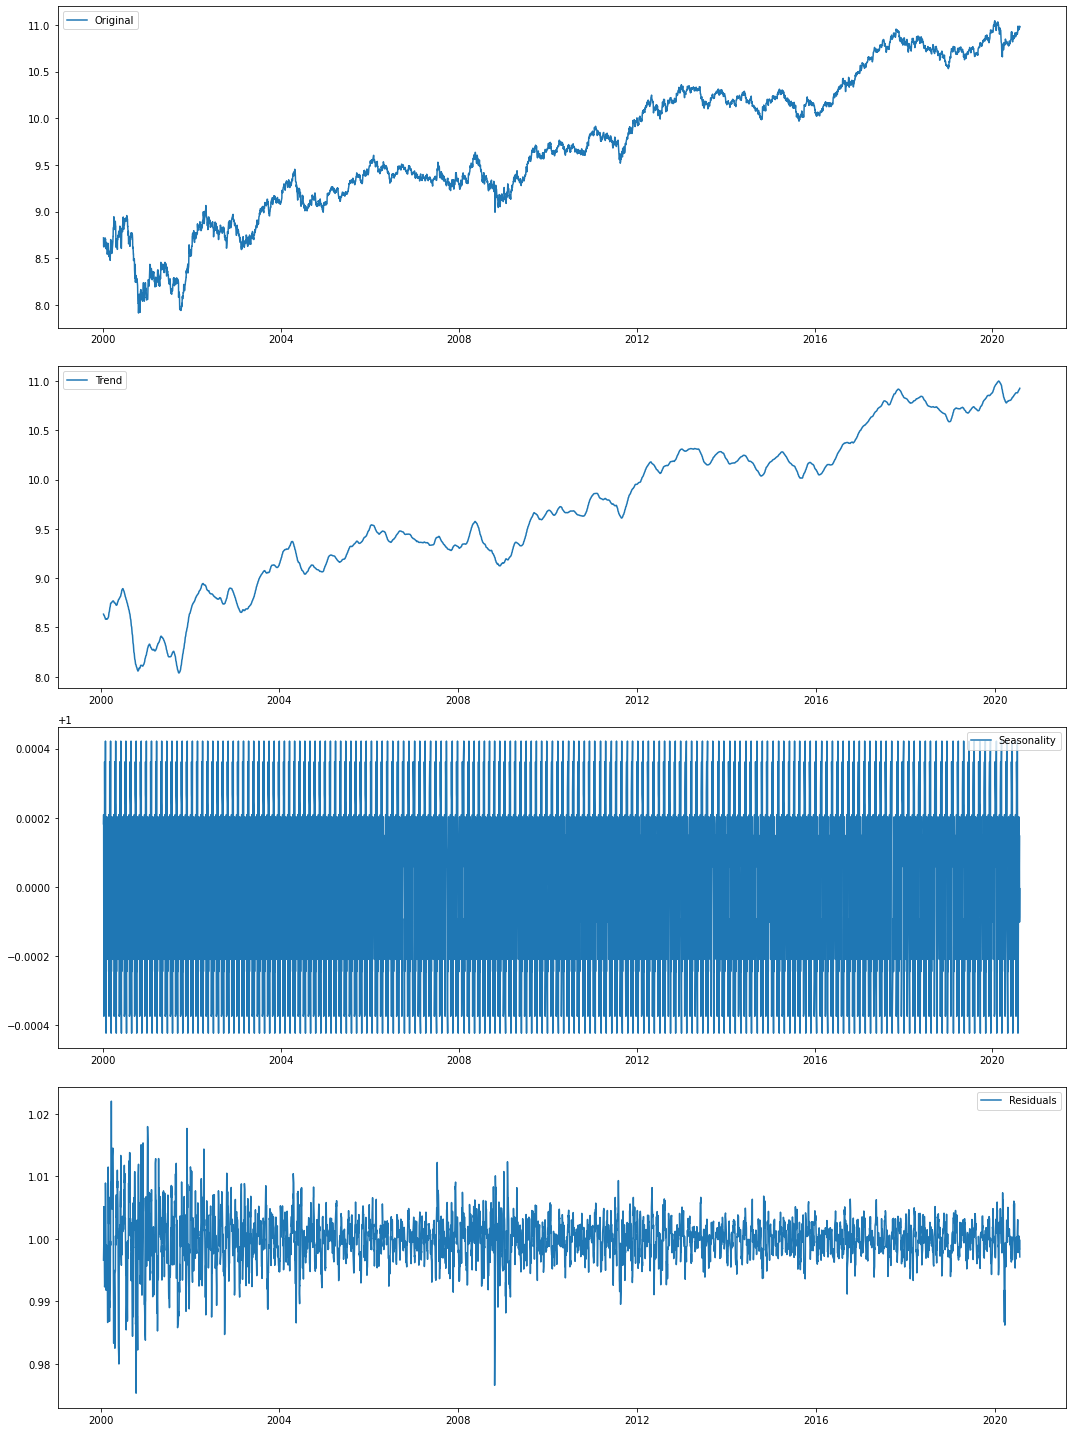

In [48]:
# 시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,20


plt.subplot(411)
plt.plot(ts_log, label="Original")
plt.legend(loc="best")
plt.subplot(412)
plt.plot(trend, label="Trend")
plt.legend(loc="best")
plt.subplot(413)
plt.plot(seasonal, label="Seasonality")
plt.legend(loc="best")
plt.subplot(414)
plt.plot(residual, label="Residuals")
plt.legend(loc="best")
plt.tight_layout()

In [39]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.728531e+01
p-value                        5.748537e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.123000e+03
Critical Value (1%)           -3.431627e+00
Critical Value (5%)           -2.862104e+00
Critical Value (10%)          -2.567070e+00
dtype: float64


## STEP 4 : 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

In [40]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

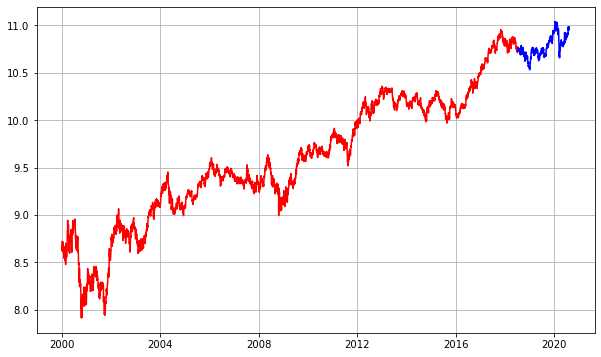

In [46]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(train_data, c="r", label="training dataset")
plt.plot(test_data, c="b", label="test dataset")

## STEP 5 : 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p, q 구하기
- 차분 안정성 확인 -> d 구하기

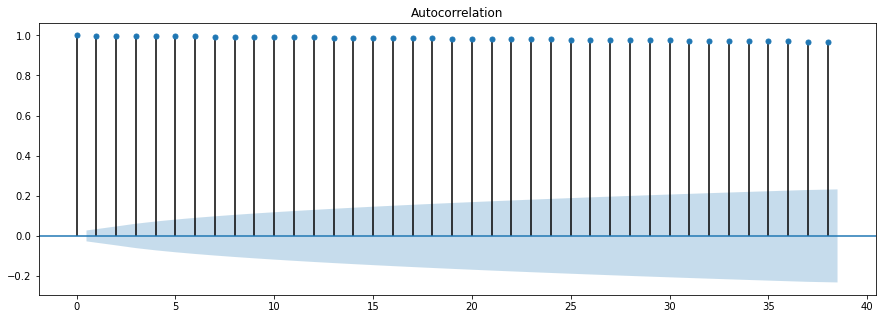

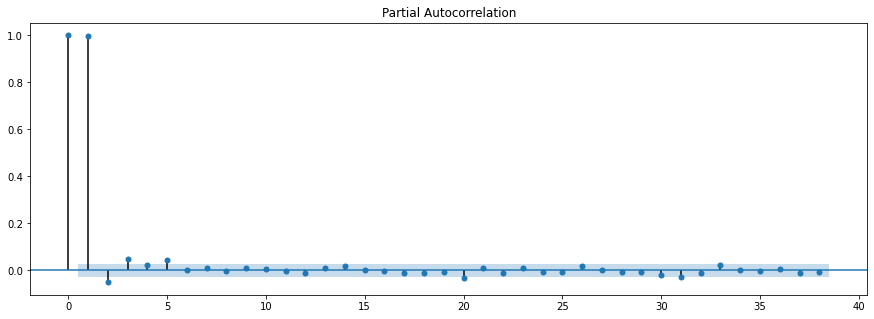

In [52]:
rcParams['figure.figsize'] = 15,5

# ACF, PACF 그려보기 -> p, q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_log)
plot_pacf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -39.817874
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5182.000000
Critical Value (1%)              -3.431613
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


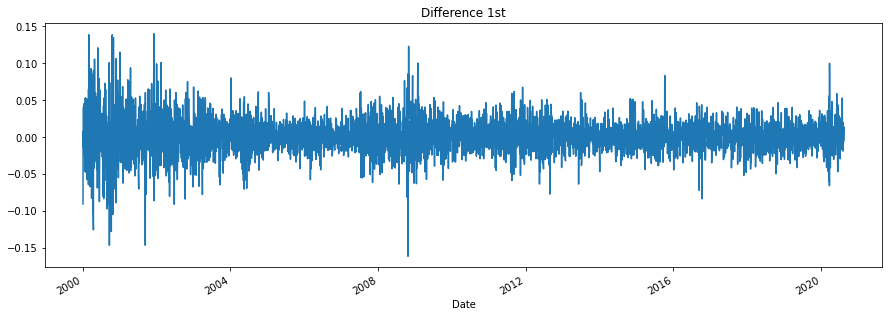

In [53]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title="Difference 1st")

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                  -21.584636
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5151.000000
Critical Value (1%)              -3.431620
Critical Value (5%)              -2.862101
Critical Value (10%)             -2.567069
dtype: float64


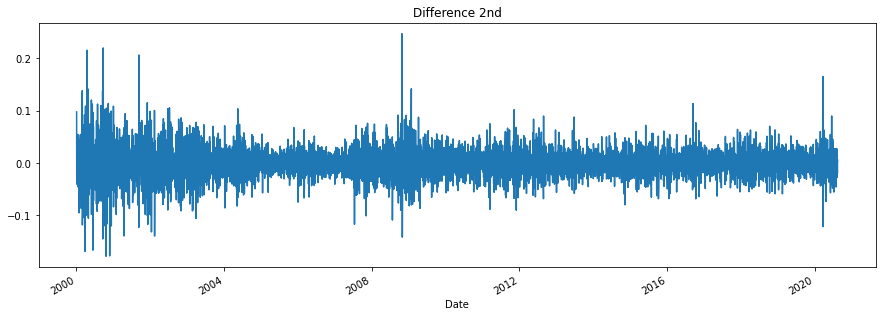

In [55]:
# 2차도 확인해보기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title="Difference 2nd")

augmented_dickey_fuller_test(diff_2)

## STEP 6 : ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [58]:
from statsmodels.tsa.arima_model import ARIMA

# Build and Train Model
model = ARIMA(train_data, order=(1,1,0)) # p=1, d=1, q=0
fitted_m = model.fit(disp=-1)
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4667
Model:                 ARIMA(1, 1, 0)   Log Likelihood               10983.285
Method:                       css-mle   S.D. of innovations              0.023
Date:                Thu, 13 Aug 2020   AIC                         -21960.569
Time:                        18:18:13   BIC                         -21941.224
Sample:                             1   HQIC                        -21953.765
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.205      0.228      -0.000       0.001
ar.L1.D.Close     0.0478      0.015      3.262      0.001       0.019       0.076
                                    Root

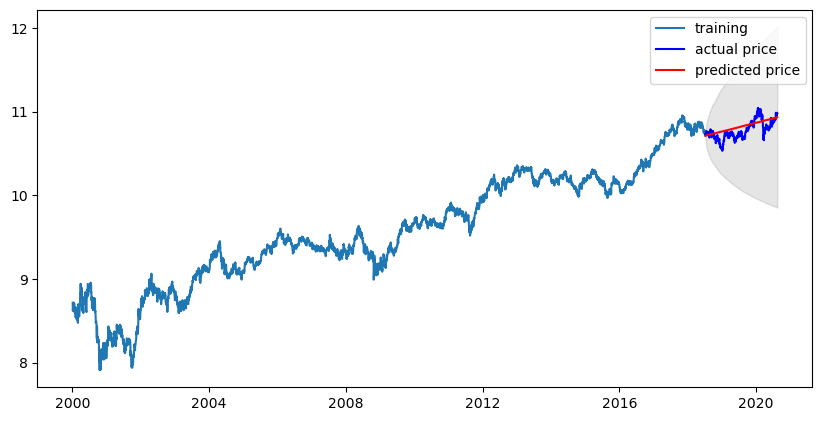

In [59]:
# Forecast : 결과가 fc에 담깁니다.
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:,0], index=test_data.index)
upper_series = pd.Series(conf[:,1], index=test_data.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r', label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series,color='k', alpha=.10)
plt.legend()
plt.show()

In [62]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE:', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE:', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE:', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE: 18517858.63179965
MAE: 3590.190001880987
RMSE: 4303.238156528134
MAPE: 7.68%


In [ ]:
## STEP 7 : 다른 주식 종목 예측해 보기